# Load and Prepare IEMOCAP and AIBO Datasets

## Prepare Label Datasets

In [1]:
%conda install openpyxl
%conda install -c conda-forge python-docx

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openpyxl


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.6.2-~ --> pkgs/main/linux-64::certifi-2024.6.2-py310h06a4308_0 
  conda              conda-forge::conda-24.5.0-py310hff520~ --> pkgs/main::conda-24.5.0-py310h06a4308_0 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - python-docx


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            pkgs/main/linux-64::certifi-2024.6.2-~ --> conda-forge/noarch::certifi-2024.6.2-pyhd8ed1ab

In [5]:
import boto3
from botocore.exceptions import NoCredentialsError
import pickle
import pandas as pd
import os

from docx import Document

In [6]:
# S3 paths
IEMOCAP_S3_PATH = 's3://ser-input/IEMOCAP/metadata_IEMOCAP.xlsx'
AIBO_S3_PATH = 's3://ser-input/AIBO/labels/IS2009EmotionChallenge/chunk_labels_5cl_corpus.docx'

# Local paths
LOCAL_DIR = './data/'
IEMOCAP_LOCAL_PATH = os.path.join(LOCAL_DIR, 'metadata_IEMOCAP.xlsx')
AIBO_LOCAL_PATH = os.path.join(LOCAL_DIR, 'chunk_labels_5cl_corpus.docx')

# Check and create local directory if it doesn't exist
os.makedirs(LOCAL_DIR, exist_ok=True)

In [8]:
# Define constants
icp_used_classes = ["neu", "hap", "sad", "ang", "fru", "exc"]
aibo_dict = {'N': 0, 'R': 1, 'P': 2, 'E': 3, 'A': 4}

In [9]:
# Load data from S3
def load_from_s3(s3_path, local_path):
    s3 = boto3.client('s3')
    bucket, key = s3_path.replace('s3://', '').split('/', 1)
    s3.download_file(bucket, key, local_path)

# Save data to pickle
def save_to_pickle(df, path):
    with open(path, 'wb') as file:
        pickle.dump(df, file, protocol=pickle.HIGHEST_PROTOCOL)

# Upload file to S3
def upload_to_s3(local_path, s3_path):
    s3 = boto3.client('s3')
    bucket, key = s3_path.replace('s3://', '').split('/', 1)
    s3.upload_file(local_path, bucket, key)

In [6]:
# Load and process IEMOCAP label data
load_from_s3(IEMOCAP_S3_PATH, IEMOCAP_LOCAL_PATH)
iemocap_df = pd.read_excel(IEMOCAP_LOCAL_PATH)
iemocap_df['gender'] = iemocap_df.ID.str[-1:].map({'M': 0, 'F': 1})
iemocap_df = iemocap_df[iemocap_df['emotion'].isin(icp_used_classes)].copy()
iemocap_df['emotion'] = iemocap_df['emotion'].replace({'exc': 'hap'})
iemocap_df = iemocap_df[['File Name', 'emotion', 'gender']]
display(iemocap_df.head())

,File Name,emotion,gender
0,Ses01F_impro01_F000,neu,1
1,Ses01F_impro01_F001,neu,1
2,Ses01F_impro01_F002,neu,1
5,Ses01F_impro01_F005,neu,1
6,Ses01F_impro01_F006,fru,1


In [7]:
# Save processed IEMOCAP data
save_to_pickle(iemocap_df, os.path.join(LOCAL_DIR, 'adults_wout_noise.pkl'))
upload_to_s3(os.path.join(LOCAL_DIR, 'adults_wout_noise.pkl'), 's3://ser-input/adults_wout_noise.pkl')

In [14]:
# Load and process AIBO data
load_from_s3(AIBO_S3_PATH, AIBO_LOCAL_PATH)
AIBO_DIR = os.path.join(LOCAL_DIR, 'AIBO/wav')

# Read DOCX file into a DataFrame
def read_docx_to_df(docx_path):
    doc = Document(docx_path)
    data = []
    for para in doc.paragraphs:
        if para.text.strip():
            data.append(para.text.split())
    df = pd.DataFrame(data, columns=['filename', 'emotion', 'confidence'])
    return df

aibo_df = read_docx_to_df(AIBO_LOCAL_PATH)
aibo_df['emotion'] = aibo_df['emotion'].map(aibo_dict)
aibo_df = aibo_df[['filename', 'emotion']]

# Add the 'path' column to the DataFrame
aibo_df['path'] = aibo_df['filename'].apply(lambda x: os.path.relpath(os.path.join(AIBO_DIR, f"{x}.wav"), LOCAL_DIR))

display(aibo_df.head())

,filename,emotion,path
0,Mont_01_000_00,0,AIBO/wav/Mont_01_000_00.wav
1,Mont_01_001_00,0,AIBO/wav/Mont_01_001_00.wav
2,Mont_01_001_01,0,AIBO/wav/Mont_01_001_01.wav
3,Mont_01_004_00,0,AIBO/wav/Mont_01_004_00.wav
4,Mont_01_005_00,0,AIBO/wav/Mont_01_005_00.wav


In [15]:
# Save processed AIBO data
save_to_pickle(aibo_df, os.path.join(LOCAL_DIR, 'children.pkl'))
upload_to_s3(os.path.join(LOCAL_DIR, 'children.pkl'), 's3://ser-input/children.pkl')

## Import wav files

In [10]:
def download_from_s3(s3_path, local_path):
    s3 = boto3.client('s3')
    bucket_name, key = s3_path.replace("s3://", "").split("/", 1)
    local_dir = os.path.dirname(local_path)
    os.makedirs(local_dir, exist_ok=True)
    try:
        s3.download_file(bucket_name, key, local_path)
        print(f"Downloaded {s3_path} to {local_path}")
    except NoCredentialsError:
        print("Credentials not available")
    except Exception as e:
        print(f"Error downloading {s3_path}: {e}")

def download_wavs_from_s3(file_paths, local_base_path):
    for file_path in file_paths:
        try:
            # Extract session/school and file name from the path
            subdir = file_path.split('/')[-2]  # SessionX for IEMOCAP, wav for AIBO
            file_name = file_path.split('/')[-1]
            # Define local path
            local_path = os.path.join(local_base_path, subdir, file_name)
            # Download file
            download_from_s3(file_path, local_path)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

def list_files_in_s3_folder(bucket, prefix):
    s3 = boto3.client('s3')
    file_paths = []
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    for page in pages:
        if 'Contents' in page:
            for obj in page['Contents']:
                file_paths.append(f"s3://{bucket}/{obj['Key']}")

    return file_paths

In [11]:
# Define the S3 bucket and prefixes
bucket_name = 'ser-input'
iemocap_prefix = 'IEMOCAP/'
aibo_prefix = 'AIBO/wav/'

In [ ]:
# Get all file paths for IEMOCAP and AIBO
iemocap_file_paths = list_files_in_s3_folder(bucket_name, iemocap_prefix)
aibo_file_paths = list_files_in_s3_folder(bucket_name, aibo_prefix)

# Download the files to respective local directories
download_wavs_from_s3(iemocap_file_paths, LOCAL_DIR + 'IEMOCAP/')
download_wavs_from_s3(aibo_file_paths, LOCAL_DIR + 'AIBO/')

Error downloading s3://ser-input/IEMOCAP/: [Errno 20] Not a directory: './data/IEMOCAP/IEMOCAP/.6FdA6DFD' -> './data/IEMOCAP/IEMOCAP/'
Downloaded s3://ser-input/IEMOCAP/IEMOCAP_with_pickle_problems.ipynb to ./data/IEMOCAP/IEMOCAP/IEMOCAP_with_pickle_problems.ipynb
Downloaded s3://ser-input/IEMOCAP/SER_with_sklearn.ipynb to ./data/IEMOCAP/IEMOCAP/SER_with_sklearn.ipynb
Downloaded s3://ser-input/IEMOCAP/Session1/Ses01F_impro01_F000.wav to ./data/IEMOCAP/Session1/Ses01F_impro01_F000.wav
Downloaded s3://ser-input/IEMOCAP/Session1/Ses01F_impro01_F000_with_10dB_noise.wav to ./data/IEMOCAP/Session1/Ses01F_impro01_F000_with_10dB_noise.wav
Downloaded s3://ser-input/IEMOCAP/Session1/Ses01F_impro01_F000_with_20dB_noise.wav to ./data/IEMOCAP/Session1/Ses01F_impro01_F000_with_20dB_noise.wav
Downloaded s3://ser-input/IEMOCAP/Session1/Ses01F_impro01_F001.wav to ./data/IEMOCAP/Session1/Ses01F_impro01_F001.wav
Downloaded s3://ser-input/IEMOCAP/Session1/Ses01F_impro01_F001_with_10dB_noise.wav to ./data/

## Add white noise to IEMOCAP

In [29]:
# Add white noise to IEMOCAP files
import scipy.io.wavfile as wav
import math
import numpy as np


def add_white_noise(file_audio, SNR=10):
    sr, signal = wav.read(file_audio)
    signal = np.interp(signal, (signal.min(), signal.max()), (-1, 1))
    RMS_s = math.sqrt(np.mean(signal**2))
    RMS_n = math.sqrt(RMS_s**2/(pow(10, SNR/10)))
    STD_n = RMS_n
    noise = np.random.normal(0, STD_n, signal.shape[0])
    signal_with_noise = signal + noise
    file_audio_name = file_audio.split('.wav')[0]
    file_final_name = "{}.wav".format(file_audio_name + "_with_{}dB_noise".format(SNR))
    wav.write(file_final_name, sr, signal_with_noise)
    return file_final_name

In [30]:
IEMOCAP_DIR = os.path.join(LOCAL_DIR, 'IEMOCAP')

# Load the original DataFrame (replace with the correct path to your pickle file)
with open(LOCAL_DIR + 'adults_wout_noise.pkl', 'rb') as f:
    adults_wout_noise_df = pickle.load(f)

In [33]:
# Add path to the original files in adults_wout_noise_df
adults_wout_noise_df['path'] = adults_wout_noise_df['File Name'].apply(lambda x: os.path.relpath(os.path.join(IEMOCAP_DIR, get_session_folder(x), f"{x}.wav"), LOCAL_DIR))

In [34]:
# List to store new rows with noise
noised_rows = []

# Function to determine session folder based on filename
def get_session_folder(filename):
    session_map = {
        'Ses01': 'Session1',
        'Ses02': 'Session2',
        'Ses03': 'Session3',
        'Ses04': 'Session4',
        'Ses05': 'Session5'
    }
    session_prefix = filename[:5]
    return session_map.get(session_prefix, 'UnknownSession')


# Iterate through the filenames and check for the presence of noise files
for idx, row in adults_wout_noise_df.iterrows():
    filename = row['File Name']
    session_folder = get_session_folder(filename)
    if session_folder == 'UnknownSession':
        print(f"Unknown session for filename {filename}. Skipping.")
        continue

    file_10dB_noise = os.path.join(IEMOCAP_DIR, session_folder, f"{filename}_with_10dB_noise.wav")
    file_20dB_noise = os.path.join(IEMOCAP_DIR, session_folder, f"{filename}_with_20dB_noise.wav")
    
    original_file = os.path.join(IEMOCAP_DIR, session_folder, f"{filename}.wav")

    # Check and add 10dB noise file if not present
    if not os.path.exists(file_10dB_noise):
        print(f"{file_10dB_noise} is missing. Adding 10dB noise to {filename}.")
        add_white_noise(original_file, SNR=10)

    # Check and add 20dB noise file if not present
    if not os.path.exists(file_20dB_noise):
        print(f"{file_20dB_noise} is missing. Adding 20dB noise to {filename}.")
        add_white_noise(original_file, SNR=20)

    # Add new rows for the noise files with emotion and gender labels
    noised_rows.append({
        'File Name': f"{filename}_with_10dB_noise",
        'path': os.path.relpath(file_10dB_noise, LOCAL_DIR),
        'emotion': row['emotion'],
        'gender': row['gender']
    })
    noised_rows.append({
        'File Name': f"{filename}_with_20dB_noise",
        'path': os.path.relpath(file_20dB_noise, LOCAL_DIR),
        'emotion': row['emotion'],
        'gender': row['gender']
    })

In [38]:
# Convert new rows to DataFrame and append to the original DataFrame
noised_rows_df = pd.DataFrame(noised_rows)
adults_wout_noise_df['path'] = adults_wout_noise_df['File Name'].apply(lambda x: os.path.relpath(os.path.join(IEMOCAP_DIR, get_session_folder(x), f"{x}.wav"), LOCAL_DIR))
adults_df = pd.concat([adults_wout_noise_df, noised_rows_df], ignore_index=True)

# Rename the column "File Name" to "filename"
adults_df = adults_df.rename(columns={"File Name": "filename"})

# Save the updated DataFrame to a pkl file
updated_pkl_path = os.path.join(LOCAL_DIR, 'adults.pkl')
save_to_pickle(adults_df, updated_pkl_path)

In [37]:
if os.path.exists(updated_pkl_path):
    print(f"File {updated_pkl_path} exists. Proceeding with upload.")
    # Upload the updated pkl file to S3
    s3_path = f's3://{bucket_name}/{iemocap_prefix}adults.pkl'
    upload_to_s3(updated_pkl_path, s3_path)
else:
    print(f"File {updated_pkl_path} does not exist. Please check the file path and try again.")

File ./data/adults.pkl exists. Proceeding with upload.


In [39]:
adults_df.head()

,filename,emotion,gender,path
0,Ses01F_impro01_F000,neu,1,IEMOCAP/Session1/Ses01F_impro01_F000.wav
1,Ses01F_impro01_F001,neu,1,IEMOCAP/Session1/Ses01F_impro01_F001.wav
2,Ses01F_impro01_F002,neu,1,IEMOCAP/Session1/Ses01F_impro01_F002.wav
3,Ses01F_impro01_F005,neu,1,IEMOCAP/Session1/Ses01F_impro01_F005.wav
4,Ses01F_impro01_F006,fru,1,IEMOCAP/Session1/Ses01F_impro01_F006.wav


In [23]:
# Display the updated DataFrame
#import ace_tools as tools; tools.display_dataframe_to_user(name="Updated Audio DataFrame", dataframe=adults_df)

## Analyse Adult Sample Distribution

In [25]:
import matplotlib.pyplot as plt


# Add session column
adults_df['session'] = adults_df['filename'].str.extract(r'(Ses0\d)')[0]

# Display the first few rows
#display(iemocap_df.head())

# Distribution of females and males in each session
gender_session_dist = adults_df.groupby(['session', 'gender']).size().unstack().fillna(0)
gender_session_dist.columns = ['Male', 'Female']
display(gender_session_dist)

,Male,Female
session,,
Ses01,714,651
Ses02,685,663
Ses03,844,689
Ses04,739,773
Ses05,770,852


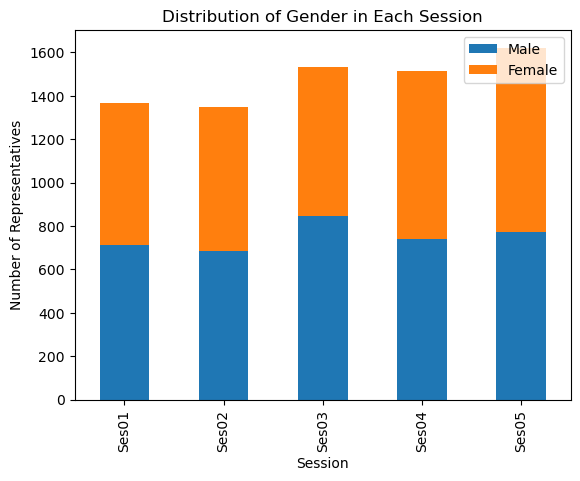

In [26]:
# Plot the distribution of gender in each session
gender_session_dist.plot(kind='bar', stacked=True)
plt.title('Distribution of Gender in Each Session')
plt.xlabel('Session')
plt.ylabel('Number of Representatives')
plt.legend(loc='upper right')
plt.show()

,Male,Female
emotion,,
ang,598,505
fru,966,883
hap,816,820
neu,797,911
sad,575,509


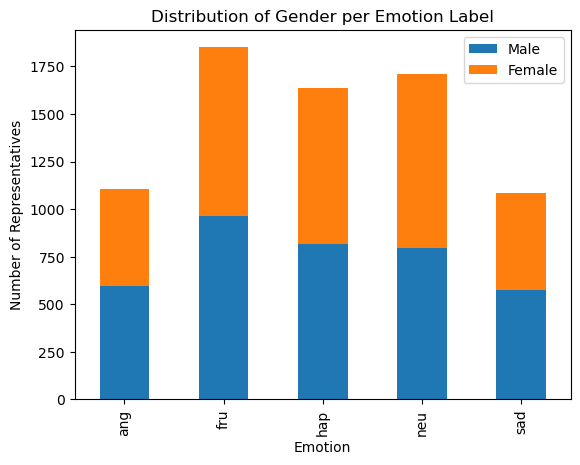

In [27]:
# Distribution of females and males per emotion label
gender_emotion_dist = adults_df.groupby(['emotion', 'gender']).size().unstack().fillna(0)
gender_emotion_dist.columns = ['Male', 'Female']
display(gender_emotion_dist)

# Plot the distribution of gender per emotion label
gender_emotion_dist.plot(kind='bar', stacked=True)
plt.title('Distribution of Gender per Emotion Label')
plt.xlabel('Emotion')
plt.ylabel('Number of Representatives')
plt.legend(loc='upper right')
plt.show()

## Analyse Children Sample Distribution

In [27]:
# Define the label dictionary and label names
aibo_label_names = {0: 'Neutral', 1: 'Rest', 2: 'Positive', 3: 'Emphatic', 4: 'Angry'}

aibo_df['label_name'] = aibo_df['label'].map(aibo_label_names)
display(aibo_df.head())

,filename,label,label_name
0,Mont_01_000_00,0,Neutral
1,Mont_01_001_00,0,Neutral
2,Mont_01_001_01,0,Neutral
3,Mont_01_004_00,0,Neutral
4,Mont_01_005_00,0,Neutral


label_name
Neutral     10967
Emphatic     3601
Angry        1492
Rest         1267
Positive      889
Name: count, dtype: int64

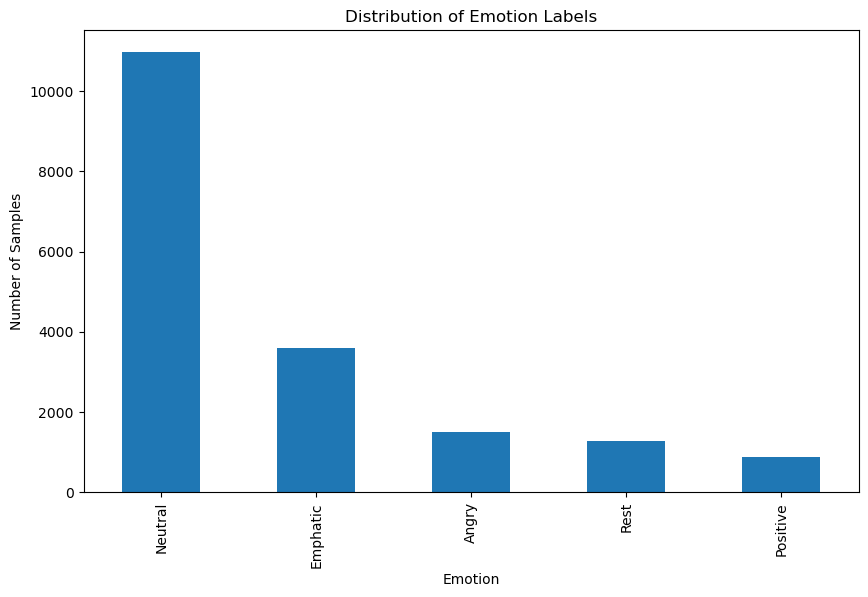

In [28]:
# Distribution of emotion labels
emotion_dist = aibo_df['label_name'].value_counts()
display(emotion_dist)

# Plot the distribution of emotion labels
plt.figure(figsize=(10, 6))
emotion_dist.plot(kind='bar')
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.show()

label_name,Angry,Emphatic,Neutral,Positive,Rest
school,,,,,
Mont,611,1508,5377,215,546
Ohm,881,2093,5590,674,721


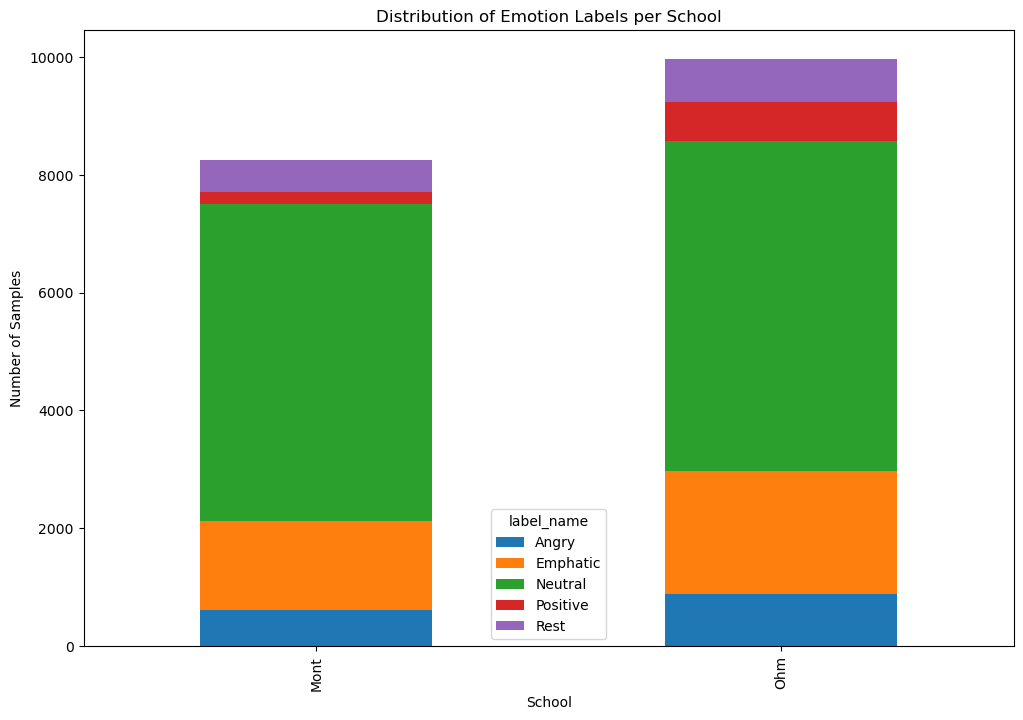

In [30]:
# Extract school from filename and drop the dummy column
aibo_df['school'] = aibo_df['filename'].apply(lambda x: x.split('_')[0])

# Distribution of emotion labels per school
school_emotion_dist = aibo_df.groupby(['school', 'label_name']).size().unstack().fillna(0)
display(school_emotion_dist)

# Plot the distribution of emotion labels per school
school_emotion_dist.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Emotion Labels per School')
plt.xlabel('School')
plt.ylabel('Number of Samples')
plt.show()